# ML extrapolate

[Source](https://gist.github.com/phillipi/038cd0322520f30ff155954a2c4f6971)

In [7]:
import jax
import optax
import jax.numpy as jnp
import flax.linen as nn

In [5]:
import numpy as np
import matplotlib.pyplot as plt

/tmp/ipykernel_327841/2562598856.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data_y[k,0] = np.expand_dims(np.array([f(data_x[k,0],true_theta)]),axis=1) + np.random.randn(1)*noise_sd


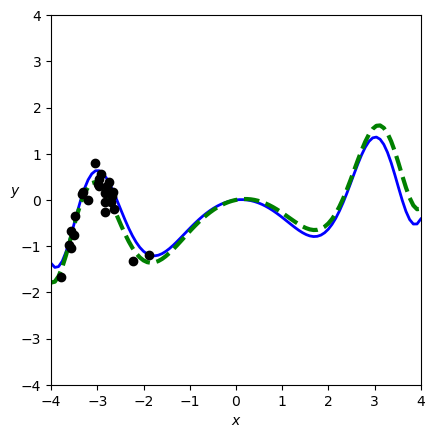

In [88]:
def mk_data(true_theta, noise_sd, N_data_points, data_mean, data_sd):
  data_x = np.expand_dims(np.random.randn(N_data_points)*data_sd + data_mean,axis=1)
  data_y = np.zeros(data_x.shape)
  for k in range(data_y.shape[0]):
    data_y[k,0] = np.expand_dims(np.array([f(data_x[k,0],true_theta)]),axis=1) + np.random.randn(1)*noise_sd
  data = np.concatenate([data_x,data_y],axis=1)
  return data

def mk_loss_map(data,f):
  theta_min = -2
  theta_max = 2
  [xx,yy] = np.meshgrid(np.linspace(theta_min,theta_max,101), np.linspace(theta_min,theta_max,101))

  data_fit_loss = np.zeros(xx.shape)

  for i in range(xx.shape[0]):
    for j in range(yy.shape[1]):
      theta = np.concatenate([xx[[i],j],yy[[i],j]],axis=0)
      for k in range(data.shape[0]):
        data_fit_loss[i,j] += loss(f(data[k,0], theta),data[k,1])
  data_fit_loss /= data.shape[0]

  return data_fit_loss, xx, yy

def get_best_theta(J,xx,yy):
  best_theta_idx = np.unravel_index(J.argmin(), J.shape)
  best_theta = np.concatenate([xx[[best_theta_idx[0]],best_theta_idx[1]], yy[[best_theta_idx[0]],best_theta_idx[1]]], axis=0)
  return best_theta

def mk_plot(J,data,true_theta,best_theta):

  u = 4
  xx = np.linspace(-u,u,101)
  plt.plot(xx,f(xx,best_theta),c='b',linewidth=2,zorder=1)
  plt.plot(xx,f(xx,true_theta),'--',c='g',linewidth=3,zorder=2)
  plt.scatter(data[:,0],data[:,1],c='k',zorder=3)
  plt.gca().set_xlim(-u,u)
  plt.gca().set_ylim(-u,u)
  plt.gca().set_aspect('equal')
  plt.gca().set_xlabel('$x$')
  plt.gca().set_ylabel('$y$',rotation=0)

def mk_fit(true_theta, noise_sd, N_data_points, data_mean, data_sd):
  data = mk_data(true_theta, noise_sd, N_data_points, data_mean, data_sd)
  J, xx, yy = mk_loss_map(data,f)
  best_theta = get_best_theta(J, xx, yy)
  return J, best_theta, data

def f(x,theta):
  y = np.sin(theta[1]*x**2) + theta[0]*x
  return y

def loss(x,y):
  return np.abs(x-y)**0.25


seed = 4
np.random.seed(seed)

true_theta = np.array([0.2,-0.5])
noise_sd = 0.2

data_mean = -3
data_sd = 0.5
N_data_points = 25
J, best_theta, data = mk_fit(true_theta, noise_sd, N_data_points, data_mean, data_sd)
mk_plot(J, data, true_theta, best_theta)

In [32]:
data = jnp.array(data)
X = data[:, [0]]
y = data[:, 1]

In [33]:
from flax.training.train_state import TrainState

In [226]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(200)(x)
        x = nn.elu(x)
        x = nn.Dense(200)(x)
        x = nn.elu(x)
        x = nn.Dense(1)(x)
        return x

In [227]:
model = MLP()
key = jax.random.PRNGKey(314)
params_init = model.init(key, X)

state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(1e-4)
)

@jax.jit
def lossfn(w):
    yhat = model.apply(w, X).ravel()
    return jnp.power(yhat - y, 2).mean()

@jax.jit
def train_step(state):
    loss, grads = jax.value_and_grad(lossfn)(state.params)
    state = state.apply_gradients(grads=jax.grad(lossfn)(state.params))
    return state, loss

losses = []
for _ in range(1_000):
    state, loss = train_step(state)
    losses.append(loss.item())

In [228]:
yhat = model.apply(state.params, X).ravel()

In [229]:
xeval = jnp.linspace(-4, 4, 100)[:, None]
yhat_eval = model.apply(state.params, xeval)

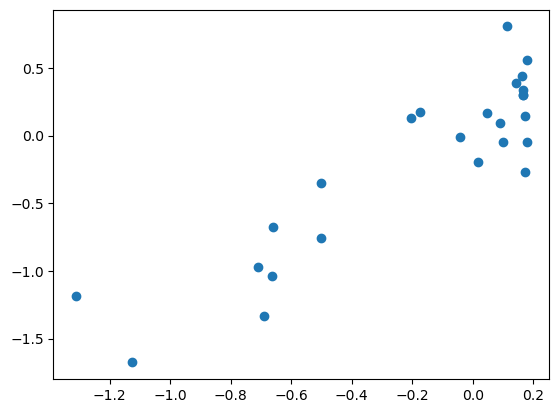

In [230]:
plt.scatter(yhat, y)

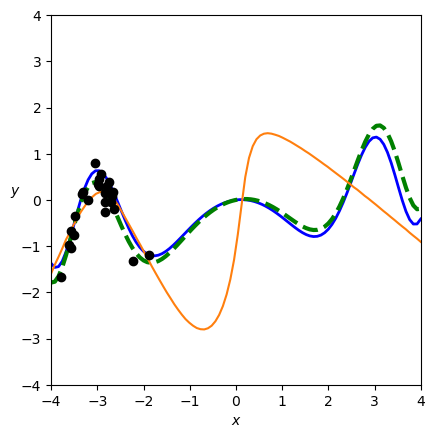

In [231]:
mk_plot(J, data, true_theta, best_theta)
plt.plot(xeval, yhat_eval, c="tab:orange")